# Sentence Tagging

In [15]:
import re

import nltk
import nltk.stem as stem
from nltk import pos_tag

import spacy

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [ ]:
nlp = spacy.load('en_core_web_md')

In [2]:
import pickle

def load_obj(name):
    with open('saved_things/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, name):
    with open('saved_things/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Tag words lists

In [48]:
import json
import pandas as pd

# GRAPES
with open('knowledge/grapes.json') as json_data:
    grapes = json.load(json_data)
    json_data.close()
    grapes = grapes['grapes']

grapes = [i.lower() for i in grapes]
gr = [" " + grape + " " for grape in grapes]


# WINE KIND
with open('knowledge/kind.json') as json_data:
    kind = json.load(json_data)
    json_data.close()
    kind = kind['kind']

kind = [i.lower() for i in kind]
kind = [" " + i.lower()+" " for i in kind]


# ITA WINENAME
with open('knowledge/appellations-it.json') as json_data:
    winename = json.load(json_data)
    json_data.close()
    winename = winename['appellations']
winename = [i.lower() for i in winename]


# USA WINENAME
winename_usa_tmp = pd.read_csv('knowledge/appellations-usa.csv')
winename_usa_tmp.iloc[:,0] = winename_usa_tmp.iloc[:,0] .map(lambda x: x.replace(' AVA',''))

winename_usa = list(winename_usa_tmp.iloc[:,0])
winename_usa = [x.lower() for x in winename_usa]

winename = winename + winename_usa

ORG = ["Winery", "Company", "Companies", "Cellar"]
org = [x.lower() for x in ORG]

places = ["Missouri", "City", 'san benito county', "new york", "COLCHAGUA VALLEY", "san luis obispo",\
          "Italy", "New Zealand", "St. Louis County", "United States", "Columbia Valley", "Carolina", "Spain", "Italia", \
          "France", "Slovenija", "Australia", "Chile", "España", "USA", "Canada", "Oregon", "California",\
          "Europe", "NAPA", "Portland", "yorkville", "Santa Clara County", "monterey county", "Oakville",\
          "Walla walla", "St Helena", "santa barbara county", "Saint Helena", "New Mexico", "Manhasset"]
places = [x.lower() for x in places]

vineyards = ['gimelli vineyards', 'Boenker Hill Vineyard', 'edna valley vineyard', 'laetitia vineyard', \
             'Lockwood Vineyards', 'Skyfall Vineyard', 'sonoma coast vineyards', 'balletto vineyards', \
             'Becker Vineyards', 'mount baker vineyards', 'guerra vineyards', 'camelot vineyard', 'pedregal vineyard', \
             'chalone vineyard', 'adastra vineyard', 'sangiovese vineyards', 'weir vineyard', \
             'spring hill vineyards', 'adelsheim vineyard', 'gunsalus vineyard', 'leaping horse vineyards', \
             'reed vineyard', 'ADIRONDACK WINERY', 'Chapelle Winery']
vineyards = [x.lower() for x in vineyards]

In [74]:
taste = ["Semi-Dry", "SemiDry", "Semi Dry", "Medium-Dry", "MediumDry",  "Medium Dry", "Dry", \
         "Semi-Sweet", "SemiSweet", "Semi Sweet", "Sweet", "Medium-Sweet", "MediumSweet", "Medium Sweet", \
         "Full-Bodied", "FullBodied", "Full Bodied", "Medium-Bodied", "MediumBodied", "Medium Bodied", \
         "Crisp", "Balance", "rough", "tannic", "tannins", "smooth", "sparkling", "finish", \
         "palate", "acidity"]
taste = [x.lower() for x in taste]

fruit = ["Honey", "Fruit", "Strawberry", "Raspberry", "Apple", "Citrus", "Vanilla", "Pineapple", "Sage", "Flower", \
         "Pear", "Mint", "Plum", "Blackberry", "Cherry", "Melon", "Peach", "Lemon", "Lime", "Mango", "Berry"]
fruit = [x.lower() for x in fruit]

with open("knowledge/list_aromas.txt", "rb") as fp:
    aromas = pickle.load(fp)

aromas1 = aromas + ['spices', 'floral', 'cork', 'ripe', 'grabby','cigar', 'guava', 'ripe', \
                 'blackberry', 'herb', 'spice', 'fresh','rind', 'structured', \
                'spice', 'espresso', 'buttercream','mineral','pepper','clove', \
                'licorice', 'tannins', 'tart', 'snappy']

aromas3 = ['red berry fruits', 'dark plum fruit', 'oak-driven aromas']

aromas2 = ['berry fruits', 'black fruit', 'red fruit', 'black cherry', 'supple plum', 'green apple', 'red apple', \
            'dried fruit','dried sage', 'dried herb', 'tropical fruit', 'baked plum', 'dark plum', 'candied berry', 'off dry', \
            'yellow flower', 'yellow fruit', 'yellow-fruit', 'white flower', 'savory herb', 'ripe pineapple',\
            'coffee beans', 'savory herb', 'white pepper', 'tannic backbone', 'coffee bean', 'apple notes' ,\
            'orange blossom']

aromas4 = ['juicy red berry fruits']

In [7]:
def sentence_setup(sent):
    
    '''preparing tuplas of sentences where the pos tag is already 
    performed, but we still have to perfrom the BIO tag. 
    Tuple form: ('word', 'verb/noun/whatever', 'O')'''
    
    lenw = 0
    tupla = []
    POS_tag = pos_tag(sent.split())
    #doc = nlp(sent)
    for idx, w in enumerate(sent.split()): 
        tupla.append((w, lenw, lenw+len(w), POS_tag[idx][1], 'O', 0))
        lenw += len(w)+1
    return tupla


# ==============================================================
# ==============================================================

def BIO_tag(label, list_of_words, sent, tupla):
    
    '''function performing BIO tag inside the tuplas'''
    
    regex = re.compile('[^a-zA-Z]')
    st = stem.RegexpStemmer('ing$|s$|y$|ly$|ed$', min=4)
    
    lenw=0
    for g in list_of_words:
        if g in sent:
            lis = g.split()
            
            if len(lis)>1: # my lis is composed of more words
                #print(lis)
                for idxx, word in enumerate(lis):
                    word = regex.sub('', word)
                    word = st.stem(word)
                    # cerco la prima parola della lista nelle tuple della frase, 
                    # cercando non per parola ma per indice della parola e lunghezza della stessa
                    for idx, t in enumerate(tupla):
                        if t[1]==sent.index(g)+lenw:
                            if t[5]==0:
                                if idxx == 0:
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(word), t[3],'B'+'-'+label, 1))
                                else:
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(word), t[3], 'I'+'-'+label, 1))
                    lenw+=len(word)+1
                    
            else: # cerco cose composte da una sola parola
                for idx, t in enumerate(tupla):
                        if regex.sub('', st.stem(t[0])) == g and t[1]==sent.index(g)+lenw:
                            if t[5]==0:
                                if (idx!=len(tupla)-1 and (tupla[idx+1][3] == 'JJ')):# or tupla[idx+1][3] == 'NN') ):
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(g), t[3], 'B'+'-'+label, 1))
                                    tupla[idx+1] = ((tupla[idx+1][0], tupla[idx+1][1], tupla[idx+1][2], tupla[idx+1][3], 'I'+'-'+ label, 1))
                                                                        
                                elif (idx!=0 and ("," not in tupla[idx-1][3]) and (tupla[idx-1][3] == 'JJ')):# or tupla[idx-1][3] == 'NN') ):
                                    tupla[idx-1] = ((tupla[idx-1][0], tupla[idx-1][1], tupla[idx-1][2], tupla[idx-1][3], 'B'+'-'+ label, 1))
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(g), t[3], 'I'+'-'+label, 1))
                                               
                                else:
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(g), t[3], 'B'+'-'+label, 1))

    return(tupla)

# ============================================================================
# ============================================================================


def labeling_function(sentences, words_tag_dict):
    
    ''' MAIN labeing function which calls sentence_setup and BIO_tag '''
    
    tag_list = []
    for i, sent in enumerate(sentences):
        if (i%50 == 0): print(i)
        sent = sent.lower()
        #sent = sent.translate(str.maketrans('', '', string.punctuation))
        sent = sent.replace(",", "").replace(".", "")
        tag_tup = sentence_setup(sent)
        
        
        for key, val in words_tag_dict.items():
            tag_tup = BIO_tag(key, val, sent, tag_tup)

        tag_list.append(tag_tup)
        
        
    return (tag_list)


# ============================================================================
# ============================================================================



def cleaning(tupla_list):
    
    '''eliminating useless informatons from tuplas'''
    
    tupla_list_cleaned = []
    for tt in tupla_list:
        tmp = []
        for t in tt:
            tmp.append((t[0], t[3], t[4]))
        tupla_list_cleaned.append(tmp)
    
    return(tupla_list_cleaned)


## Tagging reviews

In [8]:
labeled_reviews = load_obj("labeled_reviews")

sentences = [ i[0] for i in labeled_reviews ]

tokens_tag = pos_tag(labeled_reviews[2][0].split())



with open('knowledge/winemag-data-130k-v2.json') as json_data:
    reviews = json.load(json_data)
    json_data.close()
    
rev = []
for i in reviews:
    rev.append(i['description'])

In [8]:
rev[0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

In [75]:
words_tag_dict = {"aroma": aromas4, "aroma": aromas3, "aroma": aromas1, "fruit": fruit, "taste": taste}

tagged_sentences = labeling_function(rev[0:50], words_tag_dict)

tagged_sentences = cleaning(tagged_sentences)

words = []
for t in tagged_sentences:
    for w in t:
        if w[0] not in words:
            words.append(w[0])
            
words.append("ENDPAD")

0
50
100
150


In [77]:
tagged_sentences[1]

[('this', 'DT', 'O'),
 ('is', 'VBZ', 'O'),
 ('ripe', 'JJ', 'B-aroma'),
 ('and', 'CC', 'O'),
 ('fruity', 'NN', 'B-fruit'),
 ('a', 'DT', 'O'),
 ('wine', 'NN', 'O'),
 ('that', 'WDT', 'O'),
 ('is', 'VBZ', 'O'),
 ('smooth', 'VBN', 'B-taste'),
 ('while', 'IN', 'O'),
 ('still', 'RB', 'O'),
 ('structured', 'VBN', 'O'),
 ('firm', 'NN', 'O'),
 ('tannins', 'NNS', 'O'),
 ('are', 'VBP', 'O'),
 ('filled', 'VBN', 'O'),
 ('out', 'RP', 'O'),
 ('with', 'IN', 'O'),
 ('juicy', 'NN', 'O'),
 ('red', 'JJ', 'O'),
 ('berry', 'NN', 'O'),
 ('fruits', 'NNS', 'O'),
 ('and', 'CC', 'O'),
 ('freshened', 'VBN', 'O'),
 ('with', 'IN', 'O'),
 ('acidity', 'NN', 'O'),
 ("it's", 'VBP', 'O'),
 ('already', 'RB', 'O'),
 ('drinkable', 'JJ', 'O'),
 ('although', 'IN', 'O'),
 ('it', 'PRP', 'O'),
 ('will', 'MD', 'O'),
 ('certainly', 'RB', 'O'),
 ('be', 'VB', 'O'),
 ('better', 'RB', 'O'),
 ('from', 'IN', 'O'),
 ('2016', 'CD', 'O')]

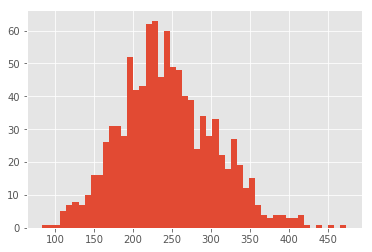

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
#save_obj(tagged_sentences, "")
#save_obj(words, "")

In [18]:
rev[0:3]

["Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",
 "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.",
 'Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.']

## Tagging wines OCRs - TO DO

In [20]:
directory = "saved_things/"

ocrs_dict = {}
with open(directory + 'ocrs_dictionary_improved.json' ) as json_data:
    ocrs_dict = json.load(json_data)
    json_data.close()
    
    
ocrs = []
for key, val in ocrs_dict.items():
    ocrs.append(val.lower())

In [52]:
words_tag_dict = {"winename": winename, "grapes": grapes, "vineyards": vineyards, "places": places, "org": org, \
                  "aroma": aromas4, "aroma": aromas3, "aroma": aromas1, "fruit": fruit, "taste": taste}

tagged_sentences = labeling_function(ocrs[0:10], words_tag_dict)

tagged_sentences = cleaning(tagged_sentences)

words = []
for t in tagged_sentences:
    for w in t:
        if w[0] not in words:
            words.append(w[0])
            
words.append("ENDPAD")

0


In [62]:
#tagged_sentences[2]